In [16]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt


## Task 1: Basics

In [17]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

In [18]:
# !unzip TestDataSet.zip

In [19]:
# preprocess images in TestDataSet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=5,)

In [20]:
import json

# Open and read the JSON file
with open('./TestDataSet/labels_list.json', 'r') as file:
    labels = json.load(file)

# Print the data
print(labels)

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

In [21]:
def get_accuracies(model, data_loader):
  model = model.to('cpu')

  correct_samples = 0
  top5_correct_samples = 0
  num_samples = 0
  accuracy = 0
  top5_acc = 0

  for step, (images, targets) in enumerate(data_loader):
    model.eval()
    outputs = model(images)
    correct_label = int(labels[step][:3])
    # calculate top1 accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_samples += preds.eq(correct_label).sum().item()
    # calulate top5 accuracy
    top5_preds = torch.topk(outputs, 5).indices
    top5_correct_samples += torch.isin(top5_preds, correct_label).sum().item()
    num_samples += images.size(0)

  accuracy = 100.0 * correct_samples / num_samples
  top5_acc = 100.0 * top5_correct_samples / num_samples
  print(f"top1 accuracy: {accuracy:.2f}%")
  print(f"top5 accuracy: {top5_acc:.2f}%")
  return accuracy, top5_acc




In [22]:
acc, top5acc = get_accuracies(pretrained_model, data_loader)

top1 accuracy: 76.00%
top5 accuracy: 94.20%


## Task 2: Pixel-Wise Attacks

In [23]:
# # https://www.kaggle.com/code/haxothermic/fgsm-against-resnet-50-on-cifar-10, modified to keep l_inf < epsilon
# def fgsm_attack(model, criterion, images, labels, device, epsilon=0.02):
#     original_images = images.clone().detach()

#     images.requires_grad_(True)
#     outputs = model(images)
#     loss = criterion(outputs, labels).to(device)
#     model.zero_grad()
#     loss.backward()

#     gradient = images.grad.data
#     l_inf_norm = torch.max(torch.abs(gradient)).item()  # max absolute gradient value


#     # Scale the gradient if its L∞ norm exceeds epsilon
#     if l_inf_norm > epsilon:
#         gradient = gradient * (epsilon / l_inf_norm)

#     perturbations = epsilon * torch.sign(gradient)
#     adversarial_images = images + perturbations
#     adversarial_images = torch.clamp(adversarial_images, 0, 1)

#     l_inf = torch.max(torch.abs(adversarial_images - original_images)).item()
#     print(f"L∞ distance: {l_inf}")

#     assert l_inf <= epsilon + 1e-6, f"Attack failed: max L∞ distance {l_inf} exceeds {epsilon}"

#     return adversarial_images, perturbations


def fgsm_attack(model, criterion, images, labels, device, epsilon=0.02):
  # Make sure model is in evaluation mode
  model.eval()

  # Save the original images for comparison
  original_images = images.clone().detach()

  # Enable gradient recording
  images.requires_grad_(True)

  # Forward pass
  outputs = model(images)

  # Calculate loss
  if criterion.__class__.__name__ == 'CrossEntropyLoss':
      # For CrossEntropyLoss, target should be class indices
      loss = criterion(outputs, labels)
  else:
      # For other losses like MSE, you might need to adjust the target format
      # For demonstration, create one-hot targets (adjust as needed)
      one_hot_targets = torch.zeros_like(outputs)
      for idx, label in enumerate(labels):
          one_hot_targets[idx, label] = 1
      loss = criterion(outputs, one_hot_targets)

  # Backward pass to get gradients
  model.zero_grad()
  loss.backward()

  # Get the sign of the gradients
  sign_data_grad = torch.sign(images.grad.data)

  # Print gradient information
  # print(f"Gradient statistics: min={images.grad.min().item()}, max={images.grad.max().item()}")
  # print(f"Epsilon: {epsilon}")

  # Create the perturbed image directly with the correct epsilon scaling
  perturbed_images = images + epsilon * sign_data_grad

  # Calculate and print the L∞ norm between original and perturbed images
  l_inf_before_clamp = torch.max(torch.abs(perturbed_images - images)).item()
  # print(f"L∞ before clamp: {l_inf_before_clamp}")

  # No need to clamp for normalized images, since the small epsilon won't push
  # them outside the valid range for model input

  # Calculate the final L∞ norm
  l_inf = torch.max(torch.abs(perturbed_images - original_images)).item()
  # print(f"Final L∞: {l_inf}")

  # Verify the constraint
  # if l_inf > epsilon + 1e-6:
  #     print(f"WARNING: L∞ distance {l_inf} exceeds epsilon {epsilon}")

  perturbed_images = torch.clamp(perturbed_images, 0, 1)

  return perturbed_images, sign_data_grad


In [24]:
def show_img(images, adversarial_images, adversarial_outputs, toCPU=False):
  pred_num, top5_preds = torch.topk(adversarial_outputs, 5)
  for idx in range(len(images)):
    if 401 not in top5_preds[idx]:
      plt.figure()
      f, axis = plt.subplots(1,3, figsize=(8, 4))
      axis[0].imshow(images[idx].cpu().T.data.numpy())
      axis[0].set_title("Original")
      axis[1].imshow(adversarial_images[idx].cpu().T.data.numpy())
      axis[1].set_title("Adversarial")
      if toCPU:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().cpu().numpy().astype(str)], pred_num[idx].detach().cpu().numpy())
      else:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().numpy().astype(str)], pred_num[idx].detach().numpy())
      axis[2].set_title("Predictions")
      plt.show()

<Figure size 640x480 with 0 Axes>

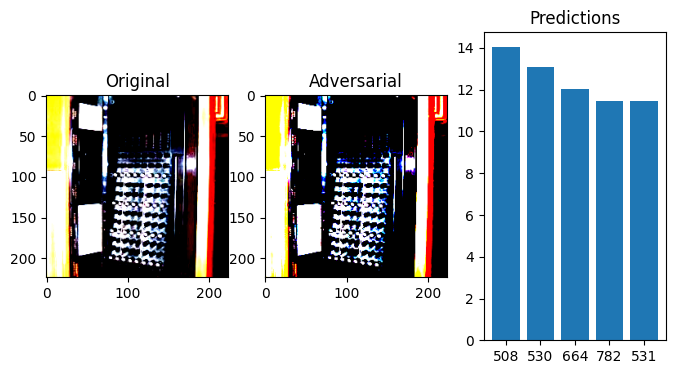

In [25]:
# create adversarial images and save as a dataset
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
AdversarialTestSet1 = [[] for _ in range(5*len(data_loader))]
for step, (images, targets) in enumerate(data_loader):
  adversarial_images, _ = fgsm_attack(pretrained_model, criterion, images, targets, device, epsilon)

  for idx in range(len(adversarial_images)):
    adversarial_images[idx] = plain_transforms(transforms.functional.to_pil_image(adversarial_images[idx]))
    AdversarialTestSet1[step*5+idx].append(adversarial_images[idx])
    AdversarialTestSet1[step*5+idx].append(targets[idx])
  adversarial_outputs = pretrained_model(adversarial_images)
  if step == 0:
    show_img(images, adversarial_images, adversarial_outputs)



In [26]:
adv_data_loader = torch.utils.data.DataLoader(AdversarialTestSet1, batch_size=5,)

In [27]:
adv1_acc, adv1_top5acc = get_accuracies(pretrained_model, adv_data_loader)


top1 accuracy: 44.40%
top5 accuracy: 66.20%


## Task 3: Improved Attacks

In [29]:


def improved_attack(model, criterion, images, labels, device, epsilon=0.02, alpha=0.005, iterations=10, target_class=None):

    model.eval()

    images = images.to(device)
    labels = labels.to(device)

    # Save original
    original_images = images.clone().detach()
    perturbed_images = original_images.clone().detach()

    for i in range(iterations):
        perturbed_images.requires_grad_(True)
        outputs = model(perturbed_images)

        # Targeted or untargeted attack logic
        if target_class is not None:
            # Create a tensor of the same target class for each image
            targeted_labels = torch.full_like(labels, target_class)

            if criterion.__class__.__name__ == 'CrossEntropyLoss':
                loss = criterion(outputs, targeted_labels)
            else:
                one_hot_targets = torch.zeros_like(outputs)
                for idx in range(len(labels)):
                    one_hot_targets[idx, target_class] = 1
                loss = criterion(outputs, one_hot_targets)

            # For targeted attack, minimize the loss toward target class
            loss = -loss  # Flip sign for gradient ascent
        else:
            # Untargeted attack: maximize the loss on true class
            if criterion.__class__.__name__ == 'CrossEntropyLoss':
                loss = criterion(outputs, labels)
            else:
                one_hot_targets = torch.zeros_like(outputs)
                for idx, label in enumerate(labels):
                    one_hot_targets[idx, label] = 1
                loss = criterion(outputs, one_hot_targets)

        model.zero_grad()
        loss.backward()
        grad_sign = torch.sign(perturbed_images.grad.data)

        perturbed_images = perturbed_images.detach() + alpha * grad_sign
        delta = perturbed_images - original_images
        delta = torch.clamp(delta, -epsilon, epsilon)
        perturbed_images = original_images + delta
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

    perturbation = perturbed_images - original_images
    l_inf = torch.max(torch.abs(perturbation)).item()
    # if l_inf > epsilon + 1e-6:
    #     print(f"WARNING: L∞ distance {l_inf} exceeds epsilon {epsilon}")

    return perturbed_images, perturbation



<Figure size 640x480 with 0 Axes>

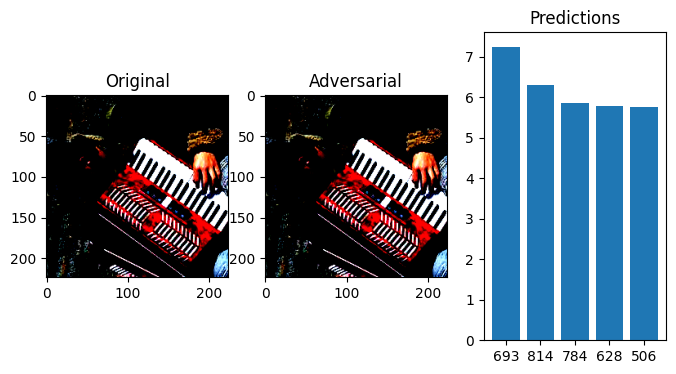

<Figure size 640x480 with 0 Axes>

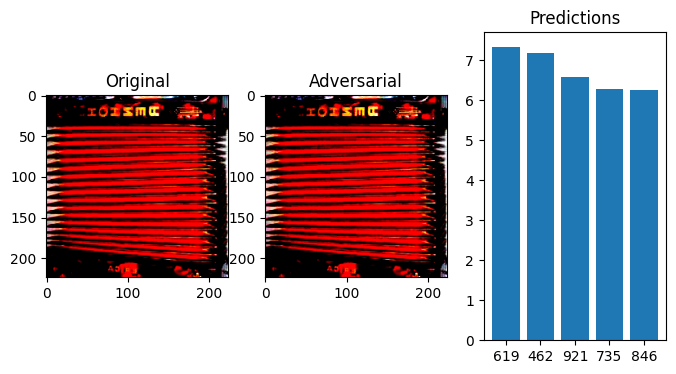

<Figure size 640x480 with 0 Axes>

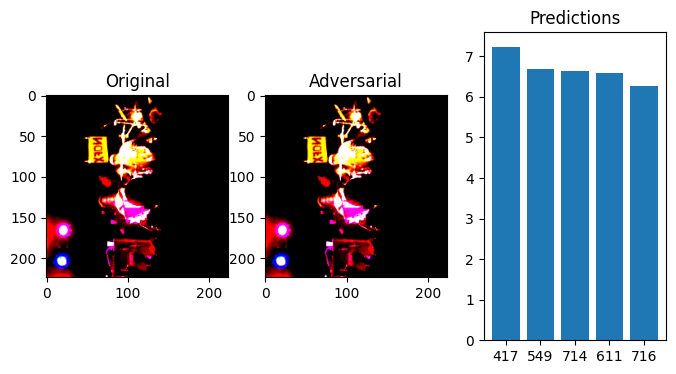

<Figure size 640x480 with 0 Axes>

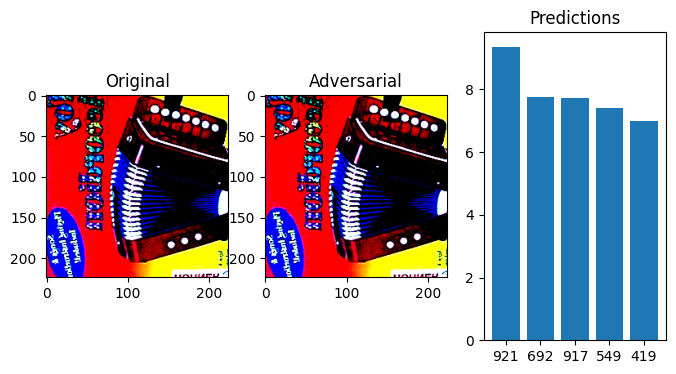

<Figure size 640x480 with 0 Axes>

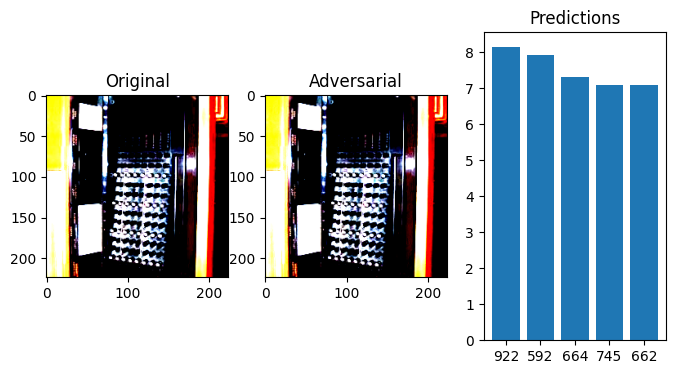

In [30]:

criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
pretrained_model = pretrained_model.to(device)

# For visualization and analysis
targeted_success_rate = 0
untargeted_success_rate = 0

AdversarialTestSet2 = [[] for _ in range(5*len(data_loader))]

# Choose a target class (e.g., 0 - could be 'plane' in CIFAR-10)
target_class = 0

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)

    # Apply the improved targeted attack
    adversarial_images, perturbation = improved_attack(
        pretrained_model,
        criterion,
        images,
        targets,
        device,
        target_class=target_class,  # Set to None to use (true_label + 1) % num_classes
        epsilon=epsilon,
        alpha=0.1,  # Step size as fraction of epsilon
        iterations=10  # Number of iterations
    )

    # Verify epsilon constraint
    # l_inf = torch.max(torch.abs(adversarial_images - images)).item()
    # assert l_inf <= epsilon + 1e-6, f"Attack failed: max L∞ distance {l_inf} exceeds {epsilon}"

    # Get model predictions on adversarial examples
    with torch.no_grad():
        adversarial_outputs = pretrained_model(adversarial_images)
        _, adv_predicted = torch.max(adversarial_outputs.data, 1)

        # Calculate untargeted success rate (how often the model is fooled)
        untargeted_success = (adv_predicted != targets).sum().item()
        untargeted_success_rate += untargeted_success

        # Calculate targeted success rate (how often the model predicts our target)
        if target_class is not None:
            targeted_labels = torch.full_like(targets, target_class)
        else:
            targeted_labels = (targets + 1) % adversarial_outputs.shape[1]

        targeted_success = (adv_predicted == targeted_labels).sum().item()
        targeted_success_rate += targeted_success

        total += targets.size(0)

    # Store adversarial examples in the dataset
    for idx in range(len(adversarial_images)):
        AdversarialTestSet2[step*5+idx].append(adversarial_images[idx].cpu())
        AdversarialTestSet2[step*5+idx].append(targets[idx].cpu())

    # Visualize the first batch
    if step == 0:
        show_img(images, adversarial_images, adversarial_outputs, True)

# # Create a DataLoader for the improved adversarial dataset
# improved_adv_data_loader = torch.utils.data.DataLoader(AdversarialTestSet2, batch_size=5)

# # Calculate accuracy on the improved adversarial dataset
# improved_adv_acc, improved_adv_top5acc = get_accuracies(pretrained_model, improved_adv_data_loader)

# # Print statistics
# print(f"Untargeted Success Rate: {untargeted_success_rate/total:.4f} ({untargeted_success_rate}/{total})")
# print(f"Targeted Success Rate: {targeted_success_rate/total:.4f} ({targeted_success_rate}/{total})")
# print(f"Model Accuracy on Improved Adversarial Examples: {improved_adv_acc:.4f}")
# print(f"Model Top-5 Accuracy on Improved Adversarial Examples: {improved_adv_top5acc:.4f}")

# Compare with original FGSM attack
# print(f"Original FGSM Attack - Model Accuracy: {adv2_acc:.4f}")
# print(f"Original FGSM Attack - Model Top-5 Accuracy: {adv2_top5acc:.4f}")

In [31]:
adv2_data_loader = torch.utils.data.DataLoader(AdversarialTestSet2, batch_size=5,)

In [32]:
adv2_acc, adv2_top5acc = get_accuracies(pretrained_model, adv2_data_loader)

top1 accuracy: 18.60%
top5 accuracy: 34.80%


## Task 4: Patch Attacks

## Task 5: Transferring Attacks

In [33]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 128MB/s]
